In [1]:
import pandas as pd
import numpy as np

from os.path import join
from matplotlib import pyplot as plt

from eyefeatures.preprocessing.fixation_extraction import IDT
from eyefeatures.features.complex import get_mtf, get_gaf, get_hilbert_curve, get_hilbert_curve_enc

DATA_PATH = join('..', 'data', 'gazes')

In [2]:
def remove_points(df, x_min, x_max, y_min, y_max):
    df = df[df['norm_pos_x'] <= x_max]
    df = df[df['norm_pos_x'] >= x_min]
    df = df[df['norm_pos_y'] >= y_min]
    df = df[df['norm_pos_y'] <= y_max]
    return df

data = pd.concat([pd.read_excel(join(DATA_PATH, 'itog_gaze_1.xlsx')),
                  pd.read_excel(join(DATA_PATH, 'itog_gaze_2.xlsx'))], axis=0)

data.drop(['world_index', 'confidence', 'base_data'], axis=1, inplace=True)
data = remove_points(data, -1, 1, -1, 1)

In [3]:
x = 'norm_pos_x'
y = 'norm_pos_y'
t = 'gaze_timestamp'
dur = 'duration'
dis = 'dispersion'

In [4]:
idt = IDT(x=x, y=y, t=t, pk=['Participant', 'tekst'], min_duration=0.01, max_dispersion=0.05,
                   distance="euc")
idt_data = idt.fit_transform(data)

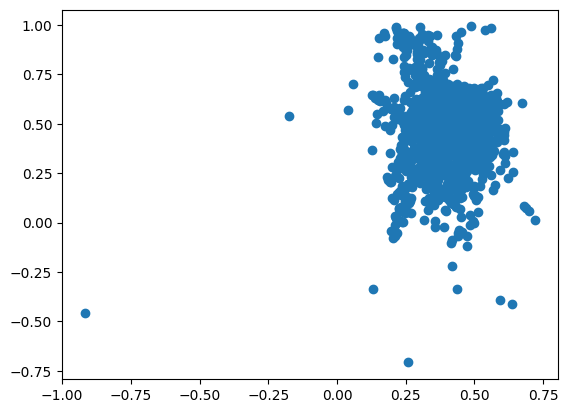

In [5]:
plt.scatter(idt_data[x].values, idt_data[y].values);

## Hilbert Curve

Get values on 1D Hilbert curve:

In [6]:
hilbert_points = get_hilbert_curve(idt_data, x, y)
hilbert_points

array([182., 133., 188., ..., 154., 154., 163.])

In [7]:
assert len(hilbert_points) == len(idt_data)

Get same values as encoded feature vector (boolean encoding):

In [8]:
p = 4  # default value

In [9]:
hilbert_enc = get_hilbert_curve_enc(idt_data, x, y, p=p)
hilbert_enc

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [10]:
assert len(hilbert_enc) == (2 ** p) * (2 ** p)

## MTF

Define shrink size and expected output size.

In [11]:
output_size = 0.95
exp_size = int(np.ceil(output_size * len(idt_data)))

Get Markov Transition Field (ordinary and using different shrink strategies):

In [12]:
mtf = get_mtf(idt_data, x, y, n_bins=10)
mtf.shape, len(idt_data)

((2, 1308, 1308), 1308)

In [13]:
mtf_shr_mean = get_mtf(idt_data, x, y, n_bins=10, output_size=output_size, shrink_strategy='mean')
mtf_shr_mean.shape, exp_size

((2, 1243, 1243), 1243)

In [14]:
mtf_shr_max = get_mtf(idt_data, x, y, n_bins=10, output_size=output_size, shrink_strategy='max')
mtf_shr_max.shape, exp_size

((2, 654, 654), 1243)

In [15]:
mtf_shr_norm = get_mtf(idt_data, x, y, n_bins=10, output_size=output_size, shrink_strategy='normal')
mtf_shr_norm.shape, exp_size

((2, 1243, 1243), 1243)

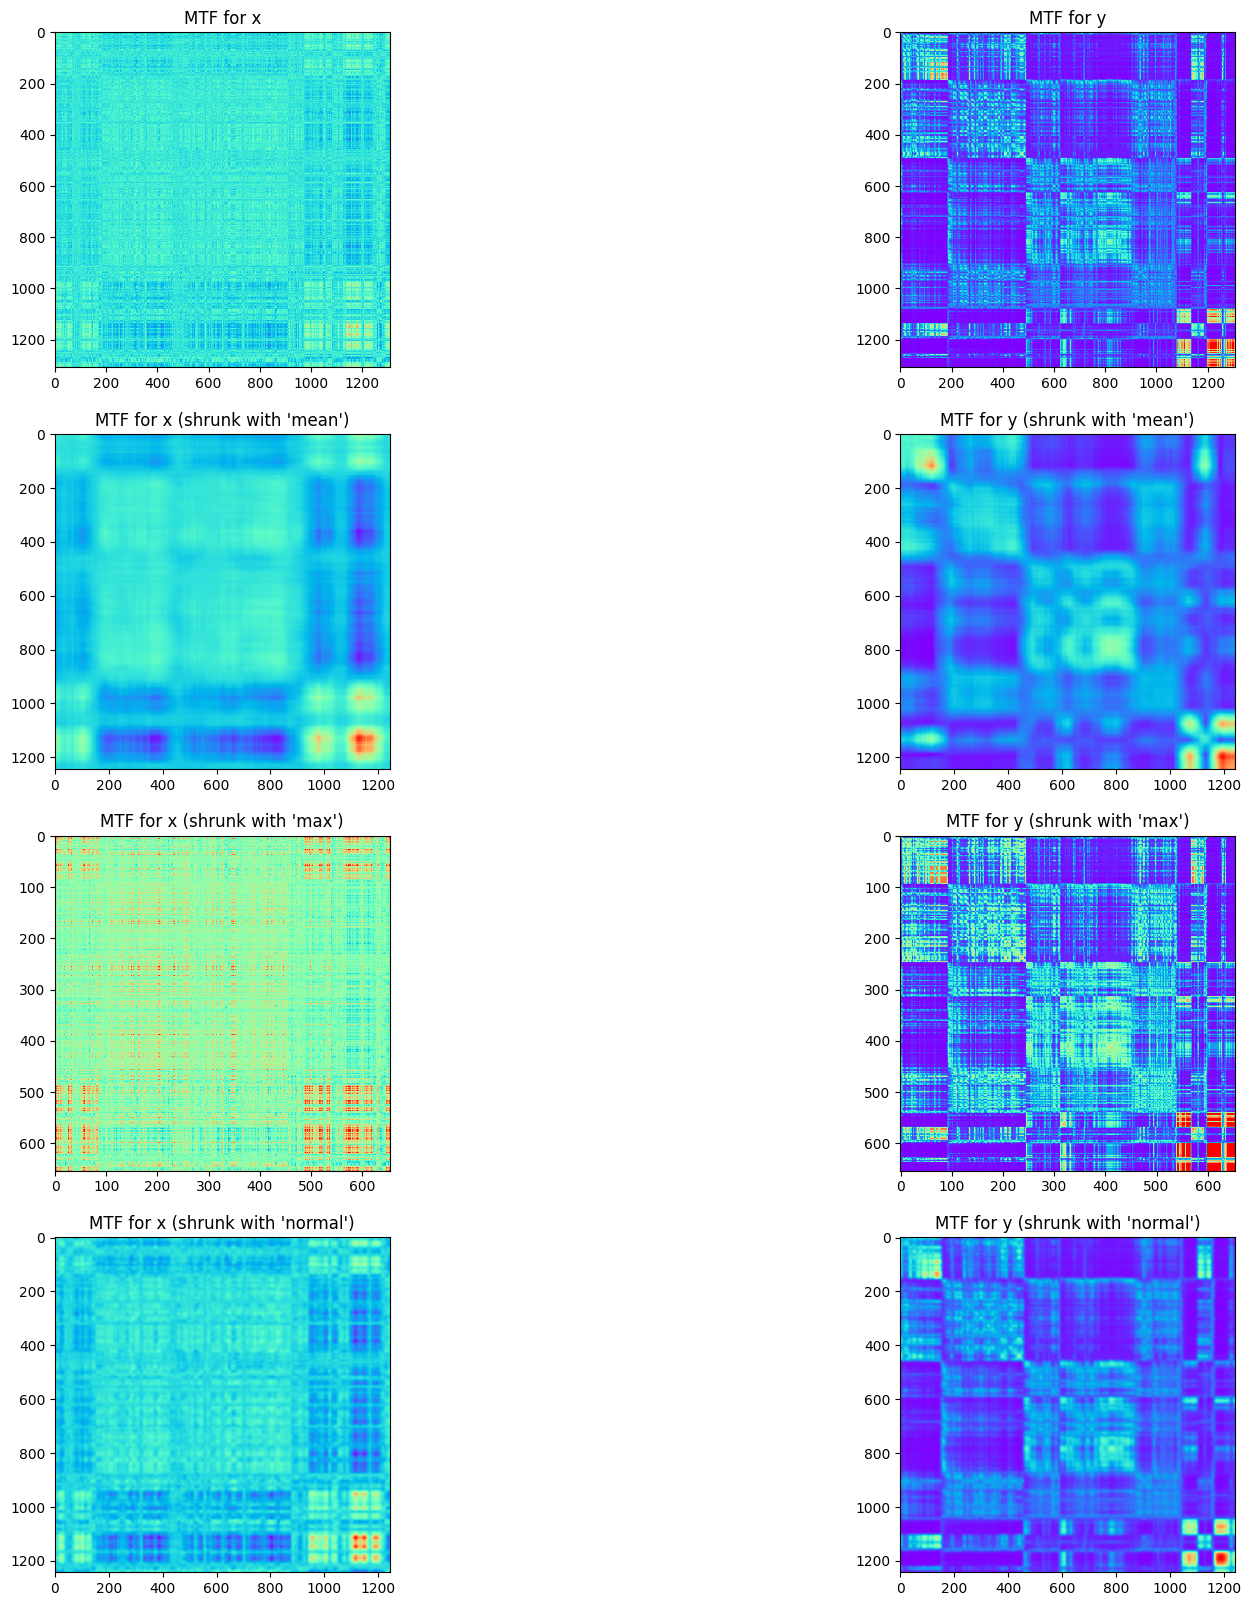

In [16]:
fig, axes = plt.subplots(4, 2, figsize=(20, 20))

addon = ("for x", "for y")
for i in range(2):
    axes[0][i].imshow(mtf[i], cmap='rainbow')
    axes[0][i].set(title=f"MTF {addon[i]}")
    axes[1][i].imshow(mtf_shr_mean[i], cmap='rainbow')
    axes[1][i].set(title=f"MTF {addon[i]} (shrunk with 'mean')")
    axes[2][i].imshow(mtf_shr_max[i], cmap='rainbow')
    axes[2][i].set(title=f"MTF {addon[i]} (shrunk with 'max')")
    axes[3][i].imshow(mtf_shr_norm[i], cmap='rainbow')
    axes[3][i].set(title=f"MTF {addon[i]} (shrunk with 'normal')")

## GAF (GASF/GADF)

Compute Gramian Angular Field using either "sum" or "difference" rule:

In [17]:
gasf_regular = get_gaf(idt_data, x, y, t='start_time', field_type='sum', to_polar='regular')
gadf_regular = get_gaf(idt_data, x, y, t='start_time', field_type='difference', to_polar='regular')
gasf_cosine = get_gaf(idt_data, x, y, t='start_time', field_type='sum', to_polar='cosine')
gadf_cosine = get_gaf(idt_data, x, y, t='start_time', field_type='difference', to_polar='cosine')

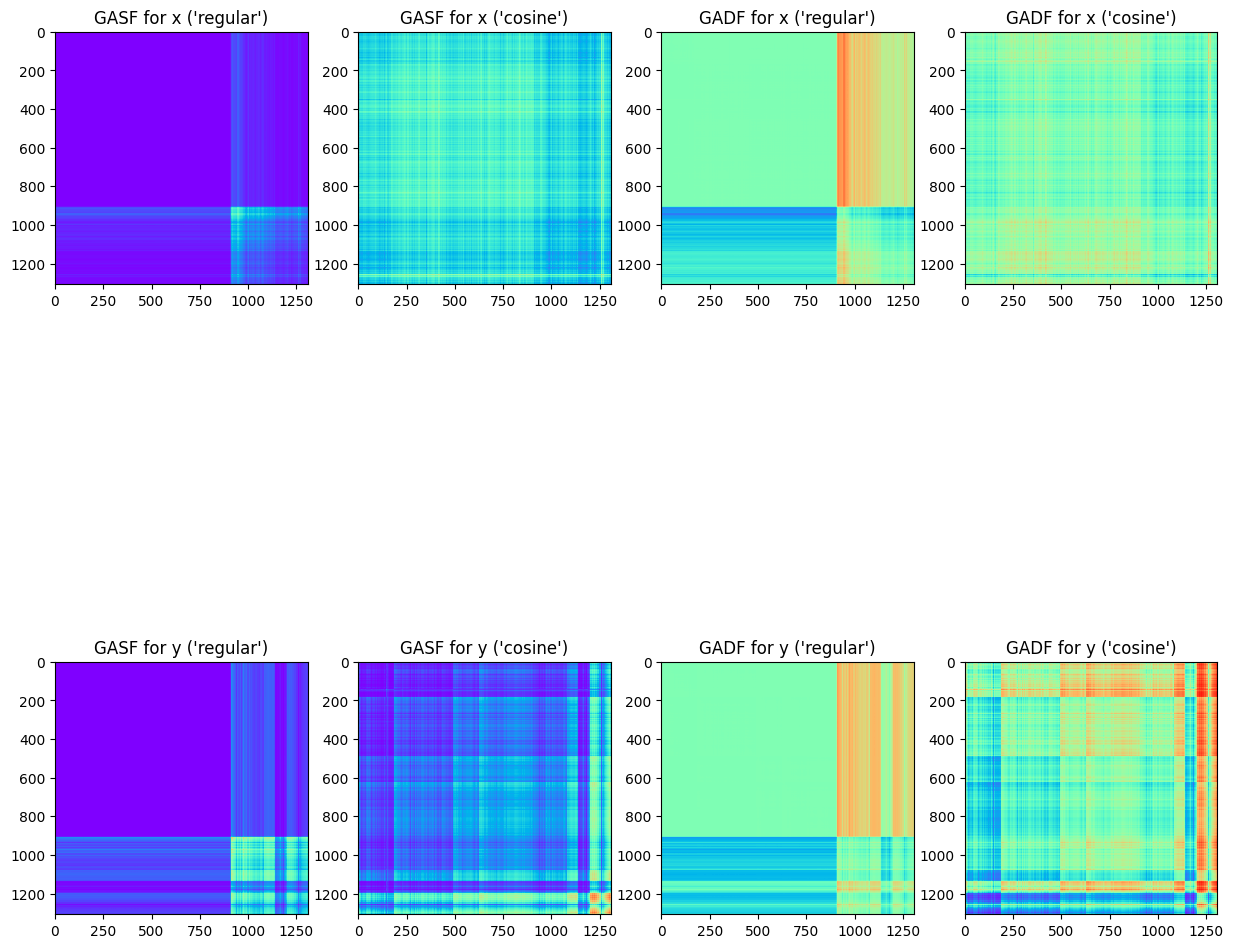

In [18]:
fig, axes = plt.subplots(2, 4, figsize=(15, 15))
c_addon = ("for x", "for y")
t_addon = ("'regular'", "'cosine'")

for i in range(2):
    axes[i][0].imshow(gasf_regular[i], cmap='rainbow')
    axes[i][0].set(title=f"GASF {c_addon[i]} ({t_addon[0]})")
    axes[i][1].imshow(gasf_cosine[i], cmap='rainbow')
    axes[i][1].set(title=f"GASF {c_addon[i]} ({t_addon[1]})")
    axes[i][2].imshow(gadf_regular[i], cmap='rainbow')
    axes[i][2].set(title=f"GADF {c_addon[i]} ({t_addon[0]})")
    axes[i][3].imshow(gadf_cosine[i], cmap='rainbow')
    axes[i][3].set(title=f"GADF {c_addon[i]} ({t_addon[1]})")